# neual-style

[リポジトリ](https://github.com/jcjohnson/neural-style)

論文の理解も浅く、コードも何をやってるのか把握しづらかったため学習用のjupyter notebook file を作成した.  

多分これを手元で動かすには以下のことをする必要がある.
- torchのセットアップ
- luarocksで各種モジュールをインストール
- VGG modluesのダウンロード

<a id="index"></a>
## <a href="#index">目次</a>
1. [モジュールの読み込み](#modules)
* [パラメータの設定](#parameters)
* [各種関数について](#functions)
* [各クラスについて](#class)
 1. [ContentLoss](#contentloss)
 * [Gram](#gram)
 * [StyleLoss](#styleloss)
 * [TVLoss](#tvloss)
* [モデルの読み込み](#model)
* [画像の読み込み](#input_image)
* [セットアップ](#setup)
* [セットアップ](#setup)
* [セットアップ](#setup)
* [セットアップ](#setup)
* [最適化](#optimization)
* [最後に...動かなくなったら](#end)

<a id="modules"></a>
## <a href="#modules">モジュールの読み込み</a>
[目次に戻る](#index)

### About Modules
- [torch](https://github.com/torch/torch7)
- [nn](https://github.com/torch/nn)
- [image](https://github.com/torch/image)
- [optim](https://github.com/torch/optim)
- [loadcaffe](https://github.com/szagoruyko/loadcaffe)

In [1]:
require 'torch'
require 'nn'
require 'image'
require 'optim'

require 'loadcaffe'

<a id="parameters"></a>
## <a href="#parameters">パラメータの設定</a>
[目次に戻る](#index)

オリジナル版ではCmdLineを使い、コマンドライン引数で指定することになっている.  
Jupyter notebook 上ではコマンドラインは使えないため各パラメータをテーブルにまとめた.

In [2]:
params = {
    -- Basic options
    style_image = 'examples/inputs/seated-nude.jpg',
    style_blend_weights = 'nil',
    content_image = 'examples/inputs/tubingen.jpg',
    image_size = 512,
    gpu = -1,
    multigpu_strategy = '',

    -- Optimization options
    content_weight = 5e0,
    style_weight = 1e2,
    tv_weight = 1e-3,
    num_iterations = 1000,
    normalize_gradients = false,
    init = 'random',
    init_image = '',
    optimizer = 'lbfgs',
    learning_rate = 1e1,
    lbfgs_num_correction = 0,

    -- Output options
    print_iter = 50,
    save_iter = 100,
    output_image = 'out.png',

    -- Other options
    style_scale = 1.0,
    original_colors = 0,
    pooling = 'max',
    proto_file = 'models/VGG_ILSVRC_19_layers_deploy.prototxt',
    model_file = 'models/VGG_ILSVRC_19_layers.caffemodel',
    backend = 'nn',
    cudnn_autotune = false,
    seed = -1,

    content_layers = 'relu4_2',
    style_layers = 'relu1_1,relu2_1,relu3_1,relu4_1,relu5_1',
}

In [3]:
print(params)

{
  style_weight : 100
  pooling : max
  seed : -1
  content_image : examples/inputs/tubingen.jpg
  save_iter : 100
  style_scale : 1
  style_image : examples/inputs/seated-nude.jpg
  optimizer : lbfgs
  style_blend_weights : nil
  num_iterations : 1000
  image_size : 512
  content_layers : relu4_2
  cudnn_autotune : false
  gpu : -1
  init_image : 
  multigpu_strategy : 
  model_file : models/VGG_ILSVRC_19_layers.caffemodel
  print_iter : 50
  backend : nn
  proto_file : models/VGG_ILSVRC_19_layers_deploy.prototxt
  original_colors : 0
  output_image : out.png
  init : random
  normalize_gradients : false
  learning_rate : 10
  style_layers : relu1_1,relu2_1,relu3_1,relu4_1,relu5_1
  content_weight : 5
  lbfgs_num_correction : 0
  tv_weight : 0.001
}


<a id="functions"></a>
## <a href="#functions">各種関数について</a>
[目次に戻る](#index)

### GPUのセットアップ

ただし、今回はCPU環境に限定するためスキップ.  
本来であれば、ここでGPU環境が使えるのであればGPU専用のパッケージに切り替える.

In [4]:
function setup_gpu(params)
    local multigpu = false
    if params.gpu:find(',') then
    multigpu = true
    params.gpu = params.gpu:split(',')
    for i = 1, #params.gpu do
      params.gpu[i] = tonumber(params.gpu[i]) + 1
    end
  else
    params.gpu = tonumber(params.gpu) + 1
  end
  local dtype = 'torch.FloatTensor'
  if multigpu or params.gpu > 0 then
    if params.backend ~= 'clnn' then
      require 'cutorch'
      require 'cunn'
      if multigpu then
        cutorch.setDevice(params.gpu[1])
      else
        cutorch.setDevice(params.gpu)
      end
      dtype = 'torch.CudaTensor'
    else
      require 'clnn'
      require 'cltorch'
      if multigpu then
        cltorch.setDevice(params.gpu[1])
      else
        cltorch.setDevice(params.gpu)
      end
      dtype = torch.Tensor():cl():type()
    end
  else
    params.backend = 'nn'
  end

  if params.backend == 'cudnn' then
    require 'cudnn'
    if params.cudnn_autotune then
      cudnn.benchmark = true
    end
    cudnn.SpatialConvolution.accGradParameters = nn.SpatialConvolutionMM.accGradParameters -- ie: nop
  end
  return dtype, multigpu
end

-- setup_gpu(params)

In [5]:
function build_filename(output_image, iteration)
  local ext = paths.extname(output_image)
  local basename = paths.basename(output_image, ext)
  local directory = paths.dirname(output_image)
  return string.format('%s/%s_%d.%s',directory, basename, iteration, ext)
end

-- Combine the Y channel of the generated image and the UV channels of the
-- content image to perform color-independent style transfer.
function original_colors(content, generated)
  local generated_y = image.rgb2yuv(generated)[{{1, 1}}]
  local content_uv = image.rgb2yuv(content)[{{2, 3}}]
  return image.yuv2rgb(torch.cat(generated_y, content_uv, 1))
end

### 前処理と戻す関数

loadcaffeに持っていくと、カラースケールが変わるためあらかじめ変換する関数.

In [6]:
-- Preprocess an image before passing it to a Caffe model.
-- We need to rescale from [0, 1] to [0, 255], convert from RGB to BGR,
-- and subtract the mean pixel.
function preprocess(img)
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
  local perm = torch.LongTensor{3, 2, 1}
  img = img:index(1, perm):mul(256.0)
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
  img:add(-1, mean_pixel)
  return img
end


-- Undo the above preprocessing.
function deprocess(img)
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
  img = img + mean_pixel
  local perm = torch.LongTensor{3, 2, 1}
  img = img:index(1, perm):div(256.0)
  return img
end

<a id="class"></a>
## <a href="#class">各クラスについて</a>
[目次に戻る](#index)

<a id="contentloss"></a>
### <a href="#contentloss">ContentLoss</a>  

In [7]:
-- Define an nn Module to compute content loss in-place
ContentLoss, parent = torch.class('nn.ContentLoss', 'nn.Module')

function ContentLoss:__init(strength, normalize)
  parent.__init(self)
  self.strength = strength
  self.target = torch.Tensor()
  self.normalize = normalize or false
  self.loss = 0
  self.crit = nn.MSECriterion()
  self.mode = 'none'
end

function ContentLoss:updateOutput(input)
  if self.mode == 'loss' then
    self.loss = self.crit:forward(input, self.target) * self.strength
  elseif self.mode == 'capture' then
    self.target:resizeAs(input):copy(input)
  end
  self.output = input
  return self.output
end

function ContentLoss:updateGradInput(input, gradOutput)
  if self.mode == 'loss' then
    if input:nElement() == self.target:nElement() then
      self.gradInput = self.crit:backward(input, self.target)
    end
    if self.normalize then
      self.gradInput:div(torch.norm(self.gradInput, 1) + 1e-8)
    end
    self.gradInput:mul(self.strength)
    self.gradInput:add(gradOutput)
  else
    self.gradInput:resizeAs(gradOutput):copy(gradOutput)
  end
  return self.gradInput
end

<a id="gram"></a>
### <a href="#gram">Gram</a>  

In [8]:
Gram, parent = torch.class('nn.GramMatrix', 'nn.Module')

function Gram:__init()
    parent.__init(self)
end

function Gram:updateOutput(input)
    assert(input:dim() == 3)
    local C, H, W = input:size(1), input:size(2), input:size(3)
    local x_flat = input:view(C, H * W)
    self.output:resize(C, C)
    self.output:mm(x_flat, x_flat:t())
    return self.output
end

function Gram:updateGradInput(input, gradOutput)
    assert(input:dim() == 3 and input:size(1))
    local C, H, W = input:size(1), input:size(2), input:size(3)
    local x_flat = input:view(C, H * W)
    self.gradInput:resize(C, H * W):mm(gradOutput, x_flat)
    self.gradInput:addmm(gradOutput:t(), x_flat)
    self.gradInput = self.gradInput:view(C, H, W)
    return self.gradInput
end

<a id="styleloss"></a>
### <a href="#styleloss">StyleLoss</a>  

In [9]:
-- Define an nn Module to compute style loss in-place
StyleLoss, parent = torch.class('nn.StyleLoss', 'nn.Module')

function StyleLoss:__init(strength, normalize)
    parent.__init(self)
    self.normalize = normalize or false
    self.strength = strength
    self.target = torch.Tensor()
    self.mode = 'none'
    self.loss = 0
    self.gram = nn.GramMatrix()
    self.blend_weight = nil
    self.G = nil
    self.crit = nn.MSECriterion()
end

function StyleLoss:updateOutput(input)
    self.G = self.gram:forward(input)
    self.G:div(input:nElement())
    if self.mode == 'capture' then
        if self.blend_weight == nil then
            self.target:resizeAs(self.G):copy(self.G)
        elseif self.target:nElement() == 0 then
            self.target:resizeAs(self.G):copy(self.G):mul(self.blend_weight)
        else
            self.target:add(self.blend_weight, self.G)
        end
    elseif self.mode == 'loss' then
        self.loss = self.strength * self.crit:forward(self.G, self.target)
    end
    self.output = input
    return self.output
end

function StyleLoss:updateGradInput(input, gradOutput)
    if self.mode == 'loss' then
        local dG = self.crit:backward(self.G, self.target)
        dG:div(input:nElement())
        self.gradInput = self.gram:backward(input, dG)
        if self.normalize then
            self.gradInput:div(torch.norm(self.gradInput, 1) + 1e-8)
        end
        self.gradInput:mul(self.strength)
        self.gradInput:add(gradOutput)
    else
        self.gradInput = gradOutput
    end
    return self.gradInput
end

<a id="tvloss"></a>
### <a href="#tvloss">TVLoss</a>  

In [10]:
TVLoss, parent = torch.class('nn.TVLoss', 'nn.Module')

function TVLoss:__init(strength)
  parent.__init(self)
  self.strength = strength
  self.x_diff = torch.Tensor()
  self.y_diff = torch.Tensor()
end

function TVLoss:updateOutput(input)
  self.output = input
  return self.output
end

-- TV loss backward pass inspired by kaishengtai/neuralart
function TVLoss:updateGradInput(input, gradOutput)
  self.gradInput:resizeAs(input):zero()
  local C, H, W = input:size(1), input:size(2), input:size(3)
  self.x_diff:resize(3, H - 1, W - 1)
  self.y_diff:resize(3, H - 1, W - 1)
  self.x_diff:copy(input[{{}, {1, -2}, {1, -2}}])
  self.x_diff:add(-1, input[{{}, {1, -2}, {2, -1}}])
  self.y_diff:copy(input[{{}, {1, -2}, {1, -2}}])
  self.y_diff:add(-1, input[{{}, {2, -1}, {1, -2}}])
  self.gradInput[{{}, {1, -2}, {1, -2}}]:add(self.x_diff):add(self.y_diff)
  self.gradInput[{{}, {1, -2}, {2, -1}}]:add(-1, self.x_diff)
  self.gradInput[{{}, {2, -1}, {1, -2}}]:add(-1, self.y_diff)
  self.gradInput:mul(self.strength)
  self.gradInput:add(gradOutput)
  return self.gradInput
end

In [11]:
dtype = 'torch.FloatTensor'

<a id="model"></a>
## <a href="#model">モデルの読み込み</a>
[目次に戻る](#index)

In [12]:
local loadcaffe_backend = params.backend
if params.backend == 'clnn' then loadcaffe_backend = 'nn' end
cnn = loadcaffe.load(params.proto_file, params.model_file, loadcaffe_backend):type(dtype)

Successfully loaded models/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3


conv3_1: 256 128 3 3
conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


<a id="input_image"></a>
## <a href="#input_image">画像の読み込み</a>
[目次に戻る](#index)

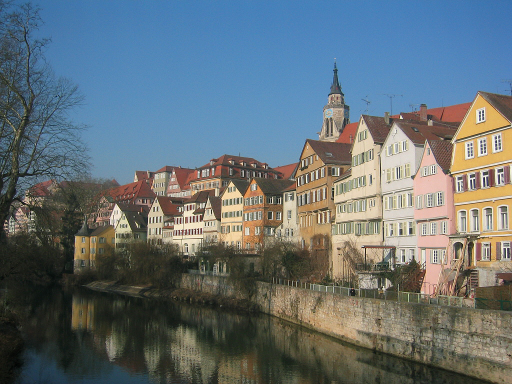

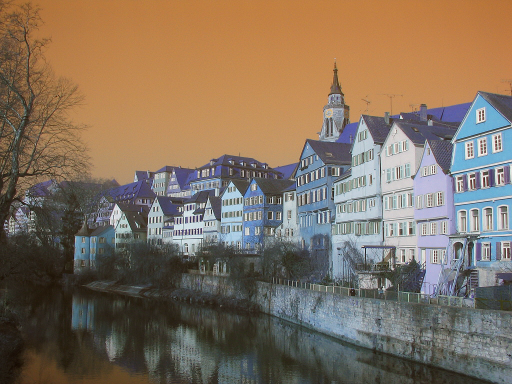

In [13]:
-- コマンドライン引数で指定した画像を読み込む。
-- さらに指定したサイズに画像をスケール変換し、loadcaffe用にカラースケールを変換する
content_image = image.load(params.content_image, 3)
content_image = image.scale(content_image, params.image_size, 'bilinear')
content_image_caffe = preprocess(content_image):float()
itorch.image(content_image)
itorch.image(content_image_caffe)

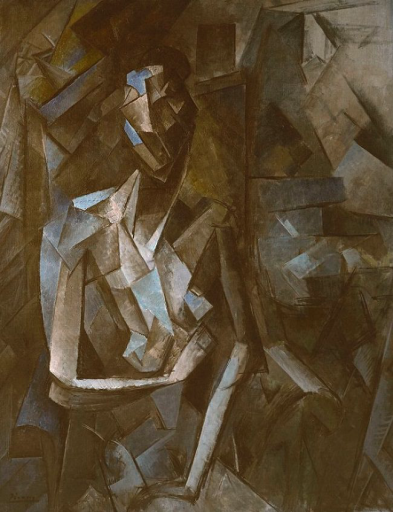

In [14]:
-- これを見る感じスタイル画像はコンマ(,)区切りでいくつか指定できるっぽい
-- 上と一緒で読み込んで、リサイズしてcafee用にカラースケールを変換している
-- 複数ある可能性があるため、それぞれテーブルにインサートしている
style_size = math.ceil(params.style_scale * params.image_size)
style_image_list = params.style_image:split(',')
style_images_caffe = {}
for _, img_path in ipairs(style_image_list) do
    local img = image.load(img_path, 3)
    img = image.scale(img, style_size, 'bilinear')
    local img_caffe = preprocess(img):float()
    table.insert(style_images_caffe, img_caffe)
end
itorch.image(style_images_caffe[1])

In [15]:
-- 何だろう？パラメータだと''が入ってるんだけど...
init_image = nil
if params.init_image ~= '' then
    init_image = image.load(params.init_image, 3)
    local H, W = content_image:size(2), content_image:size(3)
    init_image = image.scale(init_image, W, H, 'bilinear')
    init_image = preprocess(init_image):float()
end

### style image が複数あったときの処理

In [16]:
-- Handle style blending weights for multiple style inputs
style_blend_weights = nil
if params.style_blend_weights == 'nil' then
    -- Style blending not specified, so use equal weighting
    style_blend_weights = {}
    for i = 1, #style_image_list do
      table.insert(style_blend_weights, 1.0)
    end
else
    style_blend_weights = params.style_blend_weights:split(',')
    assert(#style_blend_weights == #style_image_list,
      '-style_blend_weights and -style_images must have the same number of elements')
end

In [17]:
-- Normalize the style blending weights so they sum to 1
style_blend_sum = 0
for i = 1, #style_blend_weights do
    style_blend_weights[i] = tonumber(style_blend_weights[i])
    style_blend_sum = style_blend_sum + style_blend_weights[i]
end
for i = 1, #style_blend_weights do
    style_blend_weights[i] = style_blend_weights[i] / style_blend_sum
end

<a id="setup"></a>
## <a href="#setup">セットアップ</a>
[目次に戻る](#index)

In [18]:
content_layers = params.content_layers:split(",")
style_layers = params.style_layers:split(",")

-- Set up the network, inserting style and content loss modules
content_losses, style_losses = {}, {}
next_content_idx, next_style_idx = 1, 1
net = nn.Sequential()
if params.tv_weight > 0 then
    local tv_mod = nn.TVLoss(params.tv_weight):type(dtype)
    net:add(tv_mod)
end
for i = 1, #cnn do
    if next_content_idx <= #content_layers or next_style_idx <= #style_layers then
        local layer = cnn:get(i)
        local name = layer.name
        local layer_type = torch.type(layer)
        local is_pooling = (layer_type == 'cudnn.SpatialMaxPooling' or layer_type == 'nn.SpatialMaxPooling')
        if is_pooling and params.pooling == 'avg' then
            assert(layer.padW == 0 and layer.padH == 0)
            local kW, kH = layer.kW, layer.kH
            local dW, dH = layer.dW, layer.dH
            local avg_pool_layer = nn.SpatialAveragePooling(kW, kH, dW, dH):type(dtype)
            local msg = 'Replacing max pooling at layer %d with average pooling'
            print(string.format(msg, i))
            net:add(avg_pool_layer)
        else
            net:add(layer)
        end
        if name == content_layers[next_content_idx] then
            print("Setting up content layer", i, ":", layer.name)
            local norm = params.normalize_gradients
            local loss_module = nn.ContentLoss(params.content_weight, norm):type(dtype)
            net:add(loss_module)
            table.insert(content_losses, loss_module)
            next_content_idx = next_content_idx + 1
        end
        if name == style_layers[next_style_idx] then
            print("Setting up style layer  ", i, ":", layer.name)
            local norm = params.normalize_gradients
            local loss_module = nn.StyleLoss(params.style_weight, norm):type(dtype)
            net:add(loss_module)
            table.insert(style_losses, loss_module)
            next_style_idx = next_style_idx + 1
        end
    end
end

if multigpu then
    net = setup_multi_gpu(net, params)
end
net:type(dtype)

Setting up style layer  	2	:	relu1_1	
Setting up style layer  	7	:	relu2_1	
Setting up style layer  	12	:	relu3_1	
Setting up style layer  	21	:	relu4_1	
Setting up content layer	23	:	relu4_2	
Setting up style layer  	30	:	relu5_1	


In [19]:
-- Capture content targets
for i = 1, #content_losses do
    content_losses[i].mode = 'capture'
end
print 'Capturing content targets'
print(net)
content_image_caffe = content_image_caffe:type(dtype)
net:forward(content_image_caffe:type(dtype))

Capturing content targets	
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> output]
  (1): nn.TVLoss
  (2): nn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
  (3): nn.ReLU
  (4): nn.StyleLoss
  (5): nn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
  (6): nn.ReLU
  (7): nn.SpatialMaxPooling(2x2, 2,2)
  (8): nn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
  (9): nn.ReLU
  (10): nn.StyleLoss
  (11): nn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
  (12): nn.ReLU
  (13): nn.SpatialMaxPooling(2x2, 2,2)
  (14): nn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
  (15): nn.ReLU
  (16): nn.StyleLoss
  (17): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (18): nn.ReLU
  (19): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (20): nn.

         nOutputPlane : 64
          padH : 1
          kH : 3
          weight : FloatTensor - size: 64x3x3x3
          gradWeight : FloatTensor - size: 64x3x3x3
          gradInput : FloatTensor - empty
          kW : 3
          bias : FloatTensor - size: 64
          gradBias : FloatTensor - size: 64
        }
      3 : 
        nn.ReLU
        {
          inplace : true
          threshold : 0
          _type : torch.FloatTensor
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          name : relu1_1
          val : 0
        }
      4 : 
        nn.StyleLoss
        {
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          loss : 0
          target : FloatTensor - empty
          gram : 
            nn.GramMatrix
            {
              gradInput : FloatTensor - empty
              _type : torch.FloatTensor
              output : FloatTensor - empty
            }
          normalize : false
          _type : 

          kW : 3
          bias : FloatTensor - size: 64
          gradBias : FloatTensor - size: 64
        }
      6 : 
        nn.ReLU
        {
          inplace : true
          threshold : 0
          _type : torch.FloatTensor
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          name : relu1_2
          val : 0
        }
      7 : 
        nn.SpatialMaxPooling(2x2, 2,2)
        {
          dH : 2
          dW : 2
          kW : 2
          gradInput : FloatTensor - empty
          indices : FloatTensor - empty
          name : pool1
          _type : torch.FloatTensor
          padH : 0
          ceil_mode : true
          output : FloatTensor - empty
          kH : 2
          padW : 0
        }
      8 : 
        nn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 64
          output : FloatTensor - empty
          name : conv2_1
          _type : torch.FloatTensor
          dH : 1
          

        nn.StyleLoss
        {
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          loss : 0
          target : FloatTensor - empty
          gram : 
            nn.GramMatrix
            {
              gradInput : FloatTensor - empty
              _type : torch.FloatTensor
              output : FloatTensor - empty
            }
          normalize : false
          _type : torch.FloatTensor
          strength : 100
          crit : 
            nn.MSECriterion
            {
              gradInput : FloatTensor - empty
              sizeAverage : true
              output : 0
            }
          mode : none
        }
      11 : 
        nn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 128
          output : FloatTensor - empty
          name : conv2_2
          _type : torch.FloatTensor
          dH : 1
          dW : 1
          nOutputPlane : 128
          padH : 1
          kH : 3
     

          indices : FloatTensor - empty
          name : pool2
          _type : torch.FloatTensor
          padH : 0
          ceil_mode : true
          output : FloatTensor - empty
          kH : 2
          padW : 0
        }
      14 : 
        nn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 128
          output : FloatTensor - empty
          name : conv3_1
          _type : torch.FloatTensor
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          weight : FloatTensor - size: 256x128x3x3
          gradWeight : FloatTensor - size: 256x128x3x3
          gradInput : FloatTensor - empty
          kW : 3
          bias : FloatTensor - size: 256
          gradBias : FloatTensor - size: 256
        }
      15 : 
        nn.ReLU
        {
          inplace : true
          threshold : 0
          _type : torch.FloatTensor
          output : FloatTensor - empty
          gradInput : 

          _type : torch.FloatTensor
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          name : relu3_2
          val : 0
        }
      19 : 
        nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : FloatTensor - empty
          name : conv3_3
          _type : torch.FloatTensor
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          weight : FloatTensor - size: 256x256x3x3
          gradWeight : FloatTensor - size: 256x256x3x3
          gradInput : FloatTensor - empty
          kW : 3
          bias : FloatTensor - size: 256
          gradBias : FloatTensor - size: 256
        }
      20 : 
        nn.ReLU
        {
          inplace : true
          threshold : 0
          _type : torch.FloatTensor
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          name : relu3_3
          val :

  {
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          loss : 0
          target : FloatTensor - empty
          gram : 
            nn.GramMatrix
            {
              gradInput : FloatTensor - empty
              _type : torch.FloatTensor
              output : FloatTensor - empty
            }
          normalize : false
          _type : torch.FloatTensor
          strength : 100
          crit : 
            nn.MSECriterion
            {
              gradInput : FloatTensor - empty
              sizeAverage : true
              output : 0
            }
          mode : none
        }
      27 : 
        nn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 512
          output : FloatTensor - empty
          name : conv4_2
          _type : torch.FloatTensor
          dH : 1
          dW : 1
          nOutputPlane : 512
          padH : 1
          kH : 3
          weight : FloatTensor -

          dH : 1
          dW : 1
          nOutputPlane : 512
          padH : 1
          kH : 3
          weight : FloatTensor - size: 512x512x3x3
          gradWeight : FloatTensor - size: 512x512x3x3
          gradInput : FloatTensor - empty
          kW : 3
          bias : FloatTensor - size: 512
          gradBias : FloatTensor - size: 512
        }
      33 : 
        nn.ReLU
        {
          inplace : true
          threshold : 0
          _type : torch.FloatTensor
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          name : relu4_4
          val : 0
        }
      34 : 
        nn.SpatialMaxPooling(2x2, 2,2)
        {
          dH : 2
          dW : 2
          kW : 2
          gradInput : FloatTensor - empty
          indices : FloatTensor - empty
          name : pool4
          _type : torch.FloatTensor
          padH : 0
          ceil_mode : true
          output : FloatTensor - empty
          kH : 2
          padW : 0
        }

In [20]:
-- Capture style targets
for i = 1, #content_losses do
    content_losses[i].mode = 'none'
end
for i = 1, #style_images_caffe do
    print(string.format('Capturing style target %d', i))
    for j = 1, #style_losses do
        style_losses[j].mode = 'capture'
        style_losses[j].blend_weight = style_blend_weights[i]
    end
    net:forward(style_images_caffe[i]:type(dtype))
end

Capturing style target 1	


In [21]:
  -- Set all loss modules to loss mode
  for i = 1, #content_losses do
    content_losses[i].mode = 'loss'
  end
  for i = 1, #style_losses do
    style_losses[i].mode = 'loss'
  end

In [22]:
  -- We don't need the base CNN anymore, so clean it up to save memory.
  cnn = nil
  for i=1, #net.modules do
    local module = net.modules[i]
    if torch.type(module) == 'nn.SpatialConvolutionMM' then
        -- remove these, not used, but uses gpu memory
        module.gradWeight = nil
        module.gradBias = nil
    end
  end
  collectgarbage()

In [23]:
  -- Initialize the image
  if params.seed >= 0 then
    torch.manualSeed(params.seed)
  end
  img = nil
  if params.init == 'random' then
    img = torch.randn(content_image:size()):float():mul(0.001)
  elseif params.init == 'image' then
    if init_image then
      img = init_image:clone()
    else
      img = content_image_caffe:clone()
    end
  else
    error('Invalid init type')
  end
img = img:type(dtype)

In [24]:
  -- Run it through the network once to get the proper size for the gradient
  -- All the gradients will come from the extra loss modules, so we just pass
  -- zeros into the top of the net on the backward pass.
y = net:forward(img)
dy = img.new(#y):zero()

In [25]:
-- Declaring this here lets us access it in maybe_print
  optim_state = nil
  if params.optimizer == 'lbfgs' then
    optim_state = {
      maxIter = params.num_iterations,
      verbose=true,
      tolX=-1,
      tolFun=-1,
    }
    if params.lbfgs_num_correction > 0 then
      optim_state.nCorrection = params.lbfgs_num_correction
    end
  elseif params.optimizer == 'adam' then
    optim_state = {
      learningRate = params.learning_rate,
    }
  else
    error(string.format('Unrecognized optimizer "%s"', params.optimizer))
  end

  function maybe_print(t, loss)
    local verbose = (params.print_iter > 0 and t % params.print_iter == 0)
    if verbose then
      print(string.format('Iteration %d / %d', t, params.num_iterations))
      for i, loss_module in ipairs(content_losses) do
        print(string.format('  Content %d loss: %f', i, loss_module.loss))
      end
      for i, loss_module in ipairs(style_losses) do
        print(string.format('  Style %d loss: %f', i, loss_module.loss))
      end
      print(string.format('  Total loss: %f', loss))
    end
  end

  function maybe_save(t)
    local should_save = params.save_iter > 0 and t % params.save_iter == 0
    should_save = should_save or t == params.num_iterations
    if should_save then
      local disp = deprocess(img:double())
      disp = image.minmax{tensor=disp, min=0, max=1}
      local filename = build_filename(params.output_image, t)
      if t == params.num_iterations then
        filename = params.output_image
      end
              -- Maybe perform postprocessing for color-independent style transfer
      if params.original_colors == 1 then
        disp = original_colors(content_image, disp)
      end

      image.save(filename, disp)
    end
  end

In [26]:
  -- Function to evaluate loss and gradient. We run the net forward and
  -- backward to get the gradient, and sum up losses from the loss modules.
  -- optim.lbfgs internally handles iteration and calls this function many
  -- times, so we manually count the number of iterations to handle printing
  -- and saving intermediate results.
  num_calls = 0
  function feval(x)
    num_calls = num_calls + 1
    net:forward(x)
    local grad = net:updateGradInput(x, dy)
    local loss = 0
    for _, mod in ipairs(content_losses) do
      loss = loss + mod.loss
    end
    for _, mod in ipairs(style_losses) do
      loss = loss + mod.loss
    end
    maybe_print(num_calls, loss)
    maybe_save(num_calls)

    collectgarbage()
    -- optim.lbfgs expects a vector for gradients
    return loss, grad:view(grad:nElement())
  end

<a id="optimization"></a>
## <a href="#optimization">最適化</a>
[目次に戻る](#index)

In [27]:
-- Run optimization.
if params.optimizer == 'lbfgs' then
    print('Running optimization with L-BFGS')
    local x, losses = optim.lbfgs(feval, img, optim_state)
elseif params.optimizer == 'adam' then
    print('Running optimization with ADAM')
    for t = 1, params.num_iterations do
        local x, losses = optim.adam(feval, img, optim_state)
    end
end

Running optimization with L-BFGS	


<optim.lbfgs> 	creating recyclable direction/step/history buffers	


Iteration 50 / 1000	
  Content 1 loss: 982017.734375	
  Style 1 loss: 23753.651428	
  Style 2 loss: 158210.046387	
  Style 3 loss: 32932.022095	
  Style 4 loss: 310829.150391	
  Style 5 loss: 429.459620	
  Total loss: 1508172.064295	


Iteration 100 / 1000	
  Content 1 loss: 779710.390625	
  Style 1 loss: 16605.958557	
  Style 2 loss: 73774.389648	
  Style 3 loss: 16082.989502	
  Style 4 loss: 171619.360352	
  Style 5 loss: 497.764015	
  Total loss: 1058290.852699	


Iteration 150 / 1000	
  Content 1 loss: 709929.140625	
  Style 1 loss: 10638.027191	
  Style 2 loss: 35179.214478	
  Style 3 loss: 9158.682251	
  Style 4 loss: 145332.556152	
  Style 5 loss: 511.791086	
  Total loss: 910749.411783	


Iteration 200 / 1000	
  Content 1 loss: 673160.703125	
  Style 1 loss: 6829.949951	
  Style 2 loss: 18655.383301	
  Style 3 loss: 6218.667603	
  Style 4 loss: 140170.898438	
  Style 5 loss: 531.291389	
  Total loss: 845566.893806	


Iteration 250 / 1000	
  Content 1 loss: 653594.335938	
  Style 1 loss: 4179.382324	
  Style 2 loss: 10426.514435	
  Style 3 loss: 4963.359070	
  Style 4 loss: 139957.751465	
  Style 5 loss: 545.131350	
  Total loss: 813666.474581	


Iteration 300 / 1000	
  Content 1 loss: 644538.554688	
  Style 1 loss: 2425.694275	
  Style 2 loss: 6219.165421	
  Style 3 loss: 4400.057602	
  Style 4 loss: 138480.163574	
  Style 5 loss: 553.923607	
  Total loss: 796617.559166	


Iteration 350 / 1000	
  Content 1 loss: 639545.312500	
  Style 1 loss: 1416.490936	
  Style 2 loss: 4280.170441	
  Style 3 loss: 4159.316254	
  Style 4 loss: 137438.049316	
  Style 5 loss: 558.551550	
  Total loss: 787397.890997	


Iteration 400 / 1000	
  Content 1 loss: 636255.781250	
  Style 1 loss: 881.949139	
  Style 2 loss: 3417.797089	
  Style 3 loss: 4038.522720	
  Style 4 loss: 137223.608398	
  Style 5 loss: 562.456036	
  Total loss: 782380.114632	


Iteration 450 / 1000	
  Content 1 loss: 634453.320312	
  Style 1 loss: 613.245869	
  Style 2 loss: 3010.740662	
  Style 3 loss: 3952.602768	
  Style 4 loss: 136959.338379	
  Style 5 loss: 565.121746	
  Total loss: 779554.369736	


Iteration 500 / 1000	
  Content 1 loss: 633353.554688	
  Style 1 loss: 459.749937	
  Style 2 loss: 2785.413933	
  Style 3 loss: 3916.032791	
  Style 4 loss: 136700.732422	
  Style 5 loss: 566.577053	
  Total loss: 777782.060823	


Iteration 550 / 1000	
  Content 1 loss: 632596.757812	
  Style 1 loss: 370.931363	
  Style 2 loss: 2650.156593	
  Style 3 loss: 3887.786865	
  Style 4 loss: 136514.672852	
  Style 5 loss: 567.072582	
  Total loss: 776587.378068	


Iteration 600 / 1000	
  Content 1 loss: 632051.093750	
  Style 1 loss: 315.701079	
  Style 2 loss: 2566.059685	
  Style 3 loss: 3867.541504	
  Style 4 loss: 136353.137207	
  Style 5 loss: 567.824936	
  Total loss: 775721.358161	


Iteration 650 / 1000	
  Content 1 loss: 631620.312500	
  Style 1 loss: 280.466366	
  Style 2 loss: 2507.447624	
  Style 3 loss: 3852.129364	
  Style 4 loss: 136258.093262	
  Style 5 loss: 567.980528	
  Total loss: 775086.429644	


Iteration 700 / 1000	
  Content 1 loss: 631328.320312	
  Style 1 loss: 255.086255	
  Style 2 loss: 2463.147163	
  Style 3 loss: 3833.037949	
  Style 4 loss: 136138.110352	
  Style 5 loss: 567.549658	
  Total loss: 774585.251689	


Iteration 750 / 1000	
  Content 1 loss: 631068.085938	
  Style 1 loss: 236.144185	
  Style 2 loss: 2425.137138	
  Style 3 loss: 3819.604111	
  Style 4 loss: 136035.168457	
  Style 5 loss: 567.061901	
  Total loss: 774151.201730	


Iteration 800 / 1000	
  Content 1 loss: 630750.468750	
  Style 1 loss: 221.813440	
  Style 2 loss: 2395.303917	
  Style 3 loss: 3811.167908	
  Style 4 loss: 136049.291992	
  Style 5 loss: 567.378664	
  Total loss: 773795.424671	


Iteration 850 / 1000	
  Content 1 loss: 630562.929688	
  Style 1 loss: 211.059308	
  Style 2 loss: 2371.523857	
  Style 3 loss: 3807.516861	
  Style 4 loss: 135974.755859	
  Style 5 loss: 567.446709	
  Total loss: 773495.232282	


Iteration 900 / 1000	
  Content 1 loss: 630347.031250	
  Style 1 loss: 202.957892	
  Style 2 loss: 2352.224731	
  Style 3 loss: 3802.389526	
  Style 4 loss: 135949.462891	
  Style 5 loss: 567.556095	
  Total loss: 773221.622386	


Iteration 950 / 1000	
  Content 1 loss: 630153.085938	
  Style 1 loss: 196.879411	
  Style 2 loss: 2336.878586	
  Style 3 loss: 3795.561981	
  Style 4 loss: 135940.039062	
  Style 5 loss: 567.512560	
  Total loss: 772989.957538	


Iteration 1000 / 1000	
  Content 1 loss: 629976.523438	
  Style 1 loss: 192.191684	
  Style 2 loss: 2322.924995	
  Style 3 loss: 3788.964081	
  Style 4 loss: 135933.435059	
  Style 5 loss: 567.137766	
  Total loss: 772781.177022	


<optim.lbfgs> 	reached max number of iterations	


<a id="end"></a>
## <a href="#end">最後に...動かなくなったら</a>
[目次に戻る](#index)

In [28]:
local function main(params)
  local dtype = 'torch.FloatTensor'

  local loadcaffe_backend = params.backend
  if params.backend == 'clnn' then loadcaffe_backend = 'nn' end
  local cnn = loadcaffe.load(params.proto_file, params.model_file, loadcaffe_backend):type(dtype)

  local content_image = image.load(params.content_image, 3)
  content_image = image.scale(content_image, params.image_size, 'bilinear')
  local content_image_caffe = preprocess(content_image):float()

  local style_size = math.ceil(params.style_scale * params.image_size)
  local style_image_list = params.style_image:split(',')
  local style_images_caffe = {}
  for _, img_path in ipairs(style_image_list) do
    local img = image.load(img_path, 3)
    img = image.scale(img, style_size, 'bilinear')
    local img_caffe = preprocess(img):float()
    table.insert(style_images_caffe, img_caffe)
  end

  local init_image = nil
  if params.init_image ~= '' then
    init_image = image.load(params.init_image, 3)
    local H, W = content_image:size(2), content_image:size(3)
    init_image = image.scale(init_image, W, H, 'bilinear')
    init_image = preprocess(init_image):float()
  end

  -- Handle style blending weights for multiple style inputs
  local style_blend_weights = nil
  if params.style_blend_weights == 'nil' then
    -- Style blending not specified, so use equal weighting
    style_blend_weights = {}
    for i = 1, #style_image_list do
      table.insert(style_blend_weights, 1.0)
    end
  else
    style_blend_weights = params.style_blend_weights:split(',')
    assert(#style_blend_weights == #style_image_list,
      '-style_blend_weights and -style_images must have the same number of elements')
  end
  -- Normalize the style blending weights so they sum to 1
  local style_blend_sum = 0
  for i = 1, #style_blend_weights do
    style_blend_weights[i] = tonumber(style_blend_weights[i])
    style_blend_sum = style_blend_sum + style_blend_weights[i]
  end
  for i = 1, #style_blend_weights do
    style_blend_weights[i] = style_blend_weights[i] / style_blend_sum
  end

  local content_layers = params.content_layers:split(",")
  local style_layers = params.style_layers:split(",")

  -- Set up the network, inserting style and content loss modules
  local content_losses, style_losses = {}, {}
  local next_content_idx, next_style_idx = 1, 1
  local net = nn.Sequential()
  if params.tv_weight > 0 then
    local tv_mod = nn.TVLoss(params.tv_weight):type(dtype)
    net:add(tv_mod)
  end
  for i = 1, #cnn do
    if next_content_idx <= #content_layers or next_style_idx <= #style_layers then
      local layer = cnn:get(i)
      local name = layer.name
      local layer_type = torch.type(layer)
      local is_pooling = (layer_type == 'cudnn.SpatialMaxPooling' or layer_type == 'nn.SpatialMaxPooling')
      if is_pooling and params.pooling == 'avg' then
        assert(layer.padW == 0 and layer.padH == 0)
        local kW, kH = layer.kW, layer.kH
        local dW, dH = layer.dW, layer.dH
        local avg_pool_layer = nn.SpatialAveragePooling(kW, kH, dW, dH):type(dtype)
        local msg = 'Replacing max pooling at layer %d with average pooling'
        print(string.format(msg, i))
        net:add(avg_pool_layer)
      else
        net:add(layer)
      end
      if name == content_layers[next_content_idx] then
        print("Setting up content layer", i, ":", layer.name)
        local norm = params.normalize_gradients
        local loss_module = nn.ContentLoss(params.content_weight, norm):type(dtype)
        net:add(loss_module)
        table.insert(content_losses, loss_module)
        next_content_idx = next_content_idx + 1
      end
      if name == style_layers[next_style_idx] then
        print("Setting up style layer  ", i, ":", layer.name)
        local norm = params.normalize_gradients
        local loss_module = nn.StyleLoss(params.style_weight, norm):type(dtype)
        net:add(loss_module)
        table.insert(style_losses, loss_module)
        next_style_idx = next_style_idx + 1
      end
    end
  end
  if multigpu then
    net = setup_multi_gpu(net, params)
  end
  net:type(dtype)

  -- Capture content targets
  for i = 1, #content_losses do
    content_losses[i].mode = 'capture'
  end
  print 'Capturing content targets'
  print(net)
  content_image_caffe = content_image_caffe:type(dtype)
  net:forward(content_image_caffe:type(dtype))

  -- Capture style targets
  for i = 1, #content_losses do
    content_losses[i].mode = 'none'
  end
  for i = 1, #style_images_caffe do
    print(string.format('Capturing style target %d', i))
    for j = 1, #style_losses do
      style_losses[j].mode = 'capture'
      style_losses[j].blend_weight = style_blend_weights[i]
    end
    net:forward(style_images_caffe[i]:type(dtype))
  end

  -- Set all loss modules to loss mode
  for i = 1, #content_losses do
    content_losses[i].mode = 'loss'
  end
  for i = 1, #style_losses do
    style_losses[i].mode = 'loss'
  end

  -- We don't need the base CNN anymore, so clean it up to save memory.
  cnn = nil
  for i=1, #net.modules do
    local module = net.modules[i]
    if torch.type(module) == 'nn.SpatialConvolutionMM' then
        -- remove these, not used, but uses gpu memory
        module.gradWeight = nil
        module.gradBias = nil
    end
  end
  collectgarbage()

  -- Initialize the image
  if params.seed >= 0 then
    torch.manualSeed(params.seed)
  end
  local img = nil
  if params.init == 'random' then
    img = torch.randn(content_image:size()):float():mul(0.001)
  elseif params.init == 'image' then
    if init_image then
      img = init_image:clone()
    else
      img = content_image_caffe:clone()
    end
  else
    error('Invalid init type')
  end
  img = img:type(dtype)

  -- Run it through the network once to get the proper size for the gradient
  -- All the gradients will come from the extra loss modules, so we just pass
  -- zeros into the top of the net on the backward pass.
  local y = net:forward(img)
  local dy = img.new(#y):zero()

  -- Declaring this here lets us access it in maybe_print
  local optim_state = nil
  if params.optimizer == 'lbfgs' then
    optim_state = {
      maxIter = params.num_iterations,
      verbose=true,
      tolX=-1,
      tolFun=-1,
    }
    if params.lbfgs_num_correction > 0 then
      optim_state.nCorrection = params.lbfgs_num_correction
    end
  elseif params.optimizer == 'adam' then
    optim_state = {
      learningRate = params.learning_rate,
    }
  else
    error(string.format('Unrecognized optimizer "%s"', params.optimizer))
  end

  local function maybe_print(t, loss)
    local verbose = (params.print_iter > 0 and t % params.print_iter == 0)
    if verbose then
      print(string.format('Iteration %d / %d', t, params.num_iterations))
      for i, loss_module in ipairs(content_losses) do
        print(string.format('  Content %d loss: %f', i, loss_module.loss))
      end
      for i, loss_module in ipairs(style_losses) do
        print(string.format('  Style %d loss: %f', i, loss_module.loss))
      end
      print(string.format('  Total loss: %f', loss))
    end
  end

  local function maybe_save(t)
    local should_save = params.save_iter > 0 and t % params.save_iter == 0
    should_save = should_save or t == params.num_iterations
    if should_save then
      local disp = deprocess(img:double())
      disp = image.minmax{tensor=disp, min=0, max=1}
      local filename = build_filename(params.output_image, t)
      if t == params.num_iterations then
        filename = params.output_image
      end

      -- Maybe perform postprocessing for color-independent style transfer
      if params.original_colors == 1 then
        disp = original_colors(content_image, disp)
      end

      image.save(filename, disp)
    end
  end

  -- Function to evaluate loss and gradient. We run the net forward and
  -- backward to get the gradient, and sum up losses from the loss modules.
  -- optim.lbfgs internally handles iteration and calls this function many
  -- times, so we manually count the number of iterations to handle printing
  -- and saving intermediate results.
  local num_calls = 0
  local function feval(x)
    num_calls = num_calls + 1
    net:forward(x)
    local grad = net:updateGradInput(x, dy)
    local loss = 0
    for _, mod in ipairs(content_losses) do
      loss = loss + mod.loss
    end
    for _, mod in ipairs(style_losses) do
      loss = loss + mod.loss
    end
    maybe_print(num_calls, loss)
    maybe_save(num_calls)

    collectgarbage()
    -- optim.lbfgs expects a vector for gradients
    return loss, grad:view(grad:nElement())
  end

  -- Run optimization.
  if params.optimizer == 'lbfgs' then
    print('Running optimization with L-BFGS')
    local x, losses = optim.lbfgs(feval, img, optim_state)
  elseif params.optimizer == 'adam' then
    print('Running optimization with ADAM')
    for t = 1, params.num_iterations do
      local x, losses = optim.adam(feval, img, optim_state)
    end
  end
end


function setup_gpu(params)
  local multigpu = false
  if params.gpu:find(',') then
    multigpu = true
    params.gpu = params.gpu:split(',')
    for i = 1, #params.gpu do
      params.gpu[i] = tonumber(params.gpu[i]) + 1
    end
  else
    params.gpu = tonumber(params.gpu) + 1
  end
  local dtype = 'torch.FloatTensor'
  if multigpu or params.gpu > 0 then
    if params.backend ~= 'clnn' then
      require 'cutorch'
      require 'cunn'
      if multigpu then
        cutorch.setDevice(params.gpu[1])
      else
        cutorch.setDevice(params.gpu)
      end
      dtype = 'torch.CudaTensor'
    else
      require 'clnn'
      require 'cltorch'
      if multigpu then
        cltorch.setDevice(params.gpu[1])
      else
        cltorch.setDevice(params.gpu)
      end
      dtype = torch.Tensor():cl():type()
    end
  else
    params.backend = 'nn'
  end

  if params.backend == 'cudnn' then
    require 'cudnn'
    if params.cudnn_autotune then
      cudnn.benchmark = true
    end
    cudnn.SpatialConvolution.accGradParameters = nn.SpatialConvolutionMM.accGradParameters -- ie: nop
  end
  return dtype, multigpu
end


function setup_multi_gpu(net, params)
  local DEFAULT_STRATEGIES = {
    [2] = {3},
  }
  local gpu_splits = nil
  if params.multigpu_strategy == '' then
    -- Use a default strategy
    gpu_splits = DEFAULT_STRATEGIES[#params.gpu]
    -- Offset the default strategy by one if we are using TV
    if params.tv_weight > 0 then
      for i = 1, #gpu_splits do gpu_splits[i] = gpu_splits[i] + 1 end
    end
  else
    -- Use the user-specified multigpu strategy
    gpu_splits = params.multigpu_strategy:split(',')
    for i = 1, #gpu_splits do
      gpu_splits[i] = tonumber(gpu_splits[i])
    end
  end
  assert(gpu_splits ~= nil, 'Must specify -multigpu_strategy')
  local gpus = params.gpu

  local cur_chunk = nn.Sequential()
  local chunks = {}
  for i = 1, #net do
    cur_chunk:add(net:get(i))
    if i == gpu_splits[1] then
      table.remove(gpu_splits, 1)
      table.insert(chunks, cur_chunk)
      cur_chunk = nn.Sequential()
    end
  end
  table.insert(chunks, cur_chunk)
  assert(#chunks == #gpus)

  local new_net = nn.Sequential()
  for i = 1, #chunks do
    local out_device = nil
    if i == #chunks then
      out_device = gpus[1]
    end
    new_net:add(nn.GPU(chunks[i], gpus[i], out_device))
  end

  return new_net
end


function build_filename(output_image, iteration)
  local ext = paths.extname(output_image)
  local basename = paths.basename(output_image, ext)
  local directory = paths.dirname(output_image)
  return string.format('%s/%s_%d.%s',directory, basename, iteration, ext)
end


-- Preprocess an image before passing it to a Caffe model.
-- We need to rescale from [0, 1] to [0, 255], convert from RGB to BGR,
-- and subtract the mean pixel.
function preprocess(img)
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
  local perm = torch.LongTensor{3, 2, 1}
  img = img:index(1, perm):mul(256.0)
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
  img:add(-1, mean_pixel)
  return img
end


-- Undo the above preprocessing.
function deprocess(img)
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
  img = img + mean_pixel
  local perm = torch.LongTensor{3, 2, 1}
  img = img:index(1, perm):div(256.0)
  return img
end


-- Combine the Y channel of the generated image and the UV channels of the
-- content image to perform color-independent style transfer.
function original_colors(content, generated)
  local generated_y = image.rgb2yuv(generated)[{{1, 1}}]
  local content_uv = image.rgb2yuv(content)[{{2, 3}}]
  return image.yuv2rgb(torch.cat(generated_y, content_uv, 1))
end


-- Define an nn Module to compute content loss in-place
local ContentLoss, parent = torch.class('nn.ContentLoss', 'nn.Module')

function ContentLoss:__init(strength, normalize)
  parent.__init(self)
  self.strength = strength
  self.target = torch.Tensor()
  self.normalize = normalize or false
  self.loss = 0
  self.crit = nn.MSECriterion()
  self.mode = 'none'
end

function ContentLoss:updateOutput(input)
  if self.mode == 'loss' then
    self.loss = self.crit:forward(input, self.target) * self.strength
  elseif self.mode == 'capture' then
    self.target:resizeAs(input):copy(input)
  end
  self.output = input
  return self.output
end

function ContentLoss:updateGradInput(input, gradOutput)
  if self.mode == 'loss' then
    if input:nElement() == self.target:nElement() then
      self.gradInput = self.crit:backward(input, self.target)
    end
    if self.normalize then
      self.gradInput:div(torch.norm(self.gradInput, 1) + 1e-8)
    end
    self.gradInput:mul(self.strength)
    self.gradInput:add(gradOutput)
  else
    self.gradInput:resizeAs(gradOutput):copy(gradOutput)
  end
  return self.gradInput
end


local Gram, parent = torch.class('nn.GramMatrix', 'nn.Module')

function Gram:__init()
  parent.__init(self)
end

function Gram:updateOutput(input)
  assert(input:dim() == 3)
  local C, H, W = input:size(1), input:size(2), input:size(3)
  local x_flat = input:view(C, H * W)
  self.output:resize(C, C)
  self.output:mm(x_flat, x_flat:t())
  return self.output
end

function Gram:updateGradInput(input, gradOutput)
  assert(input:dim() == 3 and input:size(1))
  local C, H, W = input:size(1), input:size(2), input:size(3)
  local x_flat = input:view(C, H * W)
  self.gradInput:resize(C, H * W):mm(gradOutput, x_flat)
  self.gradInput:addmm(gradOutput:t(), x_flat)
  self.gradInput = self.gradInput:view(C, H, W)
  return self.gradInput
end


-- Define an nn Module to compute style loss in-place
local StyleLoss, parent = torch.class('nn.StyleLoss', 'nn.Module')

function StyleLoss:__init(strength, normalize)
  parent.__init(self)
  self.normalize = normalize or false
  self.strength = strength
  self.target = torch.Tensor()
  self.mode = 'none'
  self.loss = 0

  self.gram = nn.GramMatrix()
  self.blend_weight = nil
  self.G = nil
  self.crit = nn.MSECriterion()
end

function StyleLoss:updateOutput(input)
  self.G = self.gram:forward(input)
  self.G:div(input:nElement())
  if self.mode == 'capture' then
    if self.blend_weight == nil then
      self.target:resizeAs(self.G):copy(self.G)
    elseif self.target:nElement() == 0 then
      self.target:resizeAs(self.G):copy(self.G):mul(self.blend_weight)
    else
      self.target:add(self.blend_weight, self.G)
    end
  elseif self.mode == 'loss' then
    self.loss = self.strength * self.crit:forward(self.G, self.target)
  end
  self.output = input
  return self.output
end

function StyleLoss:updateGradInput(input, gradOutput)
  if self.mode == 'loss' then
    local dG = self.crit:backward(self.G, self.target)
    dG:div(input:nElement())
    self.gradInput = self.gram:backward(input, dG)
    if self.normalize then
      self.gradInput:div(torch.norm(self.gradInput, 1) + 1e-8)
    end
    self.gradInput:mul(self.strength)
    self.gradInput:add(gradOutput)
  else
    self.gradInput = gradOutput
  end
  return self.gradInput
end


local TVLoss, parent = torch.class('nn.TVLoss', 'nn.Module')

function TVLoss:__init(strength)
  parent.__init(self)
  self.strength = strength
  self.x_diff = torch.Tensor()
  self.y_diff = torch.Tensor()
end

function TVLoss:updateOutput(input)
  self.output = input
  return self.output
end

-- TV loss backward pass inspired by kaishengtai/neuralart
function TVLoss:updateGradInput(input, gradOutput)
  self.gradInput:resizeAs(input):zero()
  local C, H, W = input:size(1), input:size(2), input:size(3)
  self.x_diff:resize(3, H - 1, W - 1)
  self.y_diff:resize(3, H - 1, W - 1)
  self.x_diff:copy(input[{{}, {1, -2}, {1, -2}}])
  self.x_diff:add(-1, input[{{}, {1, -2}, {2, -1}}])
  self.y_diff:copy(input[{{}, {1, -2}, {1, -2}}])
  self.y_diff:add(-1, input[{{}, {2, -1}, {1, -2}}])
  self.gradInput[{{}, {1, -2}, {1, -2}}]:add(self.x_diff):add(self.y_diff)
  self.gradInput[{{}, {1, -2}, {2, -1}}]:add(-1, self.x_diff)
  self.gradInput[{{}, {2, -1}, {1, -2}}]:add(-1, self.y_diff)
  self.gradInput:mul(self.strength)
  self.gradInput:add(gradOutput)
  return self.gradInput
end

-- main(params)